# Глубокий кросс-энтропийный метод

#### дедлайн задания: 19 марта, 23:59 GMT+3

В данной работе будет рассмотрено обобщение кросс-энтропийного метода на случай параметризации агента с помощью нейросети. Перед вами будет поставлена задача обучить многослойную нейронную сеть для решения простых игр в непрерывных пространствах состояний.

# Работа выполнена: Шкарбаненко Михаилом Александровичем, группа Б05-907.

Интересная работа. Я пропустил много пар...) и чтобы разобраться в происходящем использовал следующие ресурсы:

*   https://blog.paperspace.com/getting-started-with-openai-gym/
*   https://www.gymlibrary.dev/environments/classic_control/cart_pole/
*  https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.predict_proba
* https://arxiv.org/pdf/2201.09746.pdf
* Лекции  

In [127]:
# Для корректной работы ноутбука может понадобиться исполнение следующих команд
# (инструкция для Unix-подобных систем):
# !apt-get install -y xvfb x11-utils ffmpeg libav-tools python-opengl
# !pip install piglet pyvirtualdisplay gym[all]==0.18.3

In [128]:
# В Google Colab раскомментируйте это:
!wget https://bit.ly/2FMJP5K -O setup.py && bash setup.py
!pip install --upgrade gym[classic_control]==0.18.3

# XVFB будет запущен в случае исполнения на сервере
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

--2023-03-21 15:51:06--  https://bit.ly/2FMJP5K
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/setup_colab.sh [following]
--2023-03-21 15:51:07--  https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/setup_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262 [text/plain]
Saving to: ‘setup.py’

setup.py            100%[===================>]     262  --.-KB/s    in 0s      

2023-03-21 15:51:07 (16.6 MB/s) - ‘setup.py’ saved [262/262]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels

размерность вектора состояний dim = 4
n_actions = 2


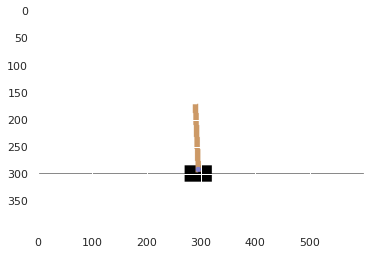

In [129]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.)

# если есть вывод "<classname> has no attribute .env", удалите .env или обновите gym
env = gym.make('CartPole-v1')

env.reset()
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"), )
print("размерность вектора состояний dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [130]:
env.observation_space, env.action_space

(Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32),
 Discrete(2))

# Нейросетевая политика, основная задача (10 баллов)

Для текущей задачи будет использована упрощённая нейронная сеть, реализованная в библиотеке __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Что для решения задачи понадобится:

* `agent.partial_fit(states, actions)` - выполнение одного прохода (одной эпохи) по данным для настройки параметров. В ходе вызова данного метода происходит приближённая максимизация вероятности :actions: при условии :states:
* `agent.predict_proba(states)` - оценка вероятностей всех действий, матрица формы __[len(states), n_actions]__


In [131]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# инициализация агента на размерности пространства состояний и пространства действий
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [132]:
def generate_session(agent, t_max=1000, test=False):
    """
    Сыграть отдельный эпизод, используя нейросетевую параметризацию агента.
    Останов после :t_max: шагов среды.
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # Используйте модель агента для оценки распределения на действия для текущего состояния :s:
        probs = agent.predict_proba([s])[0] # <Код для вывода оценки вероятности по выходу нейросети>

        assert probs.shape == (n_actions,), "Нужно получить вектор вероятностей (функция np.reshape в помощь)"
        
        # Используйте текущую оценку политики для выбора действия
        if test:
            # на тестовом прогоне или на валидации используйте
            # детерминированную стратегию
            a = np.argmax(probs) # <Выбор наиболее вероятного действия>
            # ^-- подсказка: попробуйте функцию np.argmax
        else:
            # сэмплирование пропорционально политике $\pi(a|s)$,
            # не нужно выбирать детерминированно наиболее вероятное действие
            a = np.random.choice(2, 1, p=probs)[0] # <Сэмплирование действия относительно распределения, задаваемого политикой>
            # ^-- подсказка: попробуйте функцию np.random.choice

        new_s, r, done, info = env.step(a)

        # Запись статистики текущего эпизода
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [133]:
dummy_states, dummy_actions, dummy_reward = generate_session(agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.04431389 -0.04980223 -0.01415092 -0.01929755]
 [-0.04530993  0.14551977 -0.01453687 -0.31641145]
 [-0.04239954  0.34084573 -0.0208651  -0.61364313]
 [-0.03558262  0.14602147 -0.03313796 -0.32760424]
 [-0.03266219  0.34159914 -0.03969005 -0.63055046]]
actions: [1, 1, 0, 1, 1]
reward: 5.0


### Шаги кросс-энтропийного метода
Общая схема кросс-энтропийного метода (CEM) приведена на странице 35 (параграф 2.2.4.) учебного [пособия](https://arxiv.org/pdf/2201.09746.pdf).

Глубокий CEM использует точно такую же стратегию, что и обычный CEM.

Главное отличие состоит в том, что теперь каждое наблюдение не число, а `float32` вектор.

In [134]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Выбрать states и actions из игр с rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states, elite_actions, оба 1D lists of states и actions из наилучших эпизодов

    Просьба сохранять порядок elite states и actions 
    [то есть сортированы по номерам эпизодов и в хронологическом порядке в каждом эпизоде]

    Просьба не считать по умолчанию states как целочисленные значения
    (они позже примут другой формат).
    """

    # <Ваша имплементация>

    n = len(states_batch)
    elite_states, elite_actions = [], []
    threshold = np.percentile(rewards_batch, percentile)
    for i in range(n):
        if rewards_batch[i] >= threshold:
          for state in states_batch[i]:
              elite_states.append(state)
          for action in actions_batch[i]:
              elite_actions.append(action)

    # Заметим, что это отличается от табличного случая.
    # Теперь наша нейронная сеть обучается на одном объекте с входной размерностью `(1, n_states)`.
    # То есть следует использовать `np.squeeze`, чтобы избавиться от ведущего измерения в `select_elites`.
    
    return elite_states, elite_actions

# Цикл обучения
Генерация эпизодов, выбор N лучших и обучение на них.

In [135]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    Функция-помощник, которая визуализирует процесс обучения.
    Никакой крутой математики здесь нет, только построение графиков.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    print("средняя награда = %.3f, порог=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Средние награды')
    plt.plot(list(zip(*log))[1], label='Пороги наград')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="перцентиль", color='red')
    plt.legend()
    plt.grid()

    clear_output(True)
    plt.show()

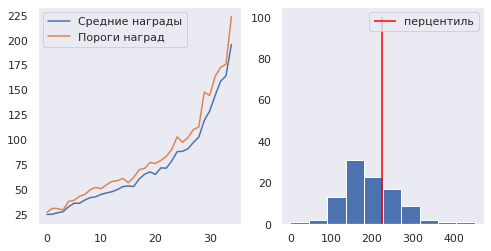

Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
CPU times: user 1min 35s, sys: 4.25 s, total: 1min 40s
Wall time: 1min 48s


In [136]:
%%time

sns.set(font_scale=1.)
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    print("Итерация метода № {}:".format(i + 1))
    # генерация новых эпизодов
    # <генерация списка из n_sessions эпизодов>
    sessions = [generate_session(agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions =  select_elites(states_batch, actions_batch, rewards_batch) # <выбор наилучшых действий с помощью select_elites()

    agent.partial_fit(elite_states, elite_actions)
    # <partial_fit агента для обучения на elite_actions (y, целевой переменной)
    # при условии elite_states (X, данных)>

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.")
        break

# Результаты

In [137]:
# запись эпизодов
import gym.wrappers
for kind, directory in [(True, "test"), (False, "sample")]:
    env = gym.wrappers.Monitor(gym.make("CartPole-v1"),
                               directory="videos/CartPole-v1/{}".format(directory), force=True)
    sessions = [generate_session(agent, test=kind) for _ in range(100)]
    env.close()

Детерминированная политика:

In [138]:
# демонстрация видео
from IPython.display import HTML
import os
from base64 import b64encode

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/CartPole-v1/test")))

v = open("./videos/CartPole-v1/test/" + video_names[-1], "rb").read()
f = "data:video/mp4;base64," + b64encode(v).decode()

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(f))

Стохастическая политика:

In [139]:
video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/CartPole-v1/sample")))

v = open("./videos/CartPole-v1/sample/" + video_names[-1], "rb").read()
f = "data:video/mp4;base64," + b64encode(v).decode()

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(f))

# Дополнительные задания

#### дедлайн дополнительного задания: за две недели до официальной даты экзамена, 23:59 GMT+3

### Глубокий кросс-энтропийный метод

На данный момент у Вас должна быть достаточно хорошая награда в [CartPole-v1](https://www.gymlibrary.dev/environments/classic_control/cart_pole/), чтобы считать основное задание выполненным (см. ссылку). Время попробовать что-нибудь посложнее.

### Задания (вплоть до 10 баллов)

* __2.1__ Выбрать одну из сред: MountainCar-v0 или LunarLander-v2.
  * Для MountainCar, получить среднее вознаграждение __как минимум -150__
  * For LunarLander, получить среднее вознаграждение __как минимум +50__

Рекомендуем обратить внимание на раздел с советами ниже, это важно.

* __2.2__ Разработать способ ускорения обучения хотя бы в два раза по сравнению с версией по умолчанию
  * Очевидное улучшение: использовать [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8) или multiprocessing
  * Попробовать переиспользовать сэмплы из 3-5 последних итераций при вычислении порога и при обучении
  * Поэкспериментировать с количеством итераций обучения и шагом метода обучения (learning rate) нейронной сети (смотеть params)
  
  
### Советы
* Страница Gym: [MountainCar](https://www.gymlibrary.dev/environments/classic_control/mountain_car/), [LunarLander](https://www.gymlibrary.dev/environments/box2d/lunar_lander/)
* Эпизоды в MountainCar могут длиться более 10k+ шагов. Убедитесь, что параметр ```t_max``` не меньше 10k.
 * Также может быть хорошей идеей строго отбирать награды через ">", а не ">=" (strictly_select_elites). Если 90% Ваших эпизодов имеют награду -10k и 20% лучше, тода если Вы используйте перцентиль 20% как порог, R >= порог __не может отклонить неуспешные эпизоды__, в то время как R > справляется с этим корректно.
* _проблема сред gym_: некоторые версии gym ограничивают эпизод 200 шагами. Это ограничивает возможности CEM в обучении в большинстве случаев. Убедитесь, что Ваш агент способен симулировать эпизоды с заданным __t_max__, и если нет, то попробуйте `env = gym.make("MountainCar-v0").env` или в ином случае избавьтесь от TimeLimit wrapper.
* Если Вы пользуетесь старой _swig_ библиотекой для LunarLander-v2, у Вас может возникнуть ошибка. Детали по [ссылке](https://github.com/openai/gym/issues/100) с решением проблемы.
* Если CEM не будет обучаться, то построение диаграмм распределения награды и запись видео эпизодов могут помочь: они Вас могут натолкнуть на идею исправления.
* 20-нейронной сети может не хватить, не стесняйтесь экспериментировать.

Ячейка с кодом ниже может оказаться полезной:

In [ ]:
def visualize_mountain_car(env, agent):
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    grid = np.dstack(np.meshgrid(xs, vs)).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3)
    return probs

Функции-помощники для инициализации среды:

In [ ]:
def get_env(name, classification=True):
    env = gym.make(name).env
    
    env.reset()
    if classification:
        n_actions = env.action_space.n
    else:
        n_actions = sum(env.action_space.shape)
    state_dim = env.observation_space.shape[0]
    
    plt.imshow(env.render("rgb_array"))
    print("state vector dim =", state_dim)
    print("n_actions =", n_actions)
    
    env.close()
    return env, n_actions, state_dim

Строгий отбор states и actions на основе перцентилей:

In [ ]:
def strictly_select_elites(states_batch, actions_batch, rewards_batch, percentile=50, classification=True):
    """
    Выбрать states и actions из игр с rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, оба 1D lists of states и actions из наилучших эпизодов

    Просьба сохранять порядок elite states и actions 
    [то есть сортированы по номерам эпизодов и в хронологическом порядке в каждом эпизоде]

    Просьба не считать по умолчанию states как целочисленные значения
    (они позже примут другой формат).
    Отбор в случае решения задачи классификации и в случае решения задачи регрессии несколько отличаются.
    """

    < Ваша имплементация >
    
    return elite_states, elite_actions

Обёртка для инициализации агента:

In [ ]:
from sklearn.neural_network import MLPRegressor


def init_agent(env, classification=True, **params):
    if classification:
        agent = MLPClassifier(
            hidden_layer_sizes=(20, 20, 20, 20),
            activation='tanh',
        )
    else:
        agent = MLPRegressor(
            hidden_layer_sizes=(20, 20, 20, 20),
            activation='tanh',
        )
    
    agent.set_params(**params)
    
    if classification:
        n_actions = env.action_space.n
        agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
    else:
        n_actions = sum(env.action_space.shape)
        if n_actions > 1:
            agent.partial_fit([env.reset()], np.random.randn(1, n_actions))
        else:
            agent.partial_fit([env.reset()], np.random.randn(n_actions))
    
    return agent

Генератор эпизодов, приспособленный к параллелизации:

In [ ]:
import pickle as pkl


def generate_parallel_session(agent, name='MountainCar-v0', t_max=10000, classification=True,
                              epsilon=0.01, agent_mul_fac=1.0, test=False, env=None):
    """
    Сыграть отдельный эпизод, используя нейросетевую параметризацию агента.
    Останов после :t_max: шагов среды.
    """
    
    states, actions = [], []
    total_reward = 0
    
    if env is None:
        env = gym.make(name).env
    if classification:
        n_actions = env.action_space.n
    else:
        n_actions = sum(env.action_space.shape)
    s = env.reset()

    for t in range(t_max):
        
        if classification:
            probs = < оценка вероятностей нейросетевой модели >

            assert probs.shape == (n_actions,), "Нужно получить вектор вероятностей" +\
                "(функция np.reshape в помощь)"
            
            if test:
                a = < наиболее вероятное действия относительно probs >
            else:
                a = < сэмпл действия из распределения probs >
        else:
            expected_action = < оценка с помощью модели среднего действия, помноженного на agent_mul_fac >
            
            if test:
                a = < само expected_action >
            else:
                a = < сэмпл из Normal(expected_action, epsilon) >

        new_s, r, done, info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    
    del env, s, new_s, a
    
    return states, actions, total_reward

Функция для обучения агента:

In [ ]:
from collections import deque
from multiprocessing import Pool
from functools import partial


def train_agent(classification=True, epsilon=0.01, name='MountainCar-v0', n_train_steps=100,
                n_game_steps=10000, n_sessions=100, percentile=70, goal_score=-150, history_length=4,
                n_jobs=16, verbose=True, agent_mul_fac=1.0, **params):
    env = gym.make(name).env
    if classification:
        n_actions = env.action_space.n
    else:
        n_actions = sum(env.action_space.shape)
    
    agent = init_agent(env, classification, **params)
    
    if verbose:
        print('Шаг агента = {}'.format(agent.learning_rate_init), flush=True)
    
    log = []
    sessions = deque([], history_length * n_sessions)
    
    for i in range(n_train_steps):
        if n_jobs > 1:
            pool = Pool(processes=n_jobs, maxtasksperchild=10)
            sessions.extend(pool.map(partial(generate_parallel_session, agent, name, n_game_steps,
                                             classification, epsilon, agent_mul_fac), [False] * n_sessions))
            pool.close()
            pool.join()
            del pool
        else:
            sessions.extend([generate_parallel_session(
                agent, name, n_game_steps, classification, epsilon, agent_mul_fac,
                False) for _ in range(n_sessions)])
        
        states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
        elite_states, elite_actions = strictly_select_elites(
            states_batch, actions_batch, rewards_batch, percentile, classification)
        
        if classification:
            agent.partial_fit(elite_states, elite_actions)
        else:
            elite_actions = elite_actions if (len(elite_actions.shape) < 2) or (elite_actions.shape[1] > 1)\
                            else elite_actions.reshape(-1)
            agent.partial_fit(elite_states, elite_actions / agent_mul_fac)
        
        if verbose:
            inter_min = np.min(rewards_batch)
            min_lim = -n_game_steps if -n_game_steps < inter_min else inter_min
            inter_max = np.max(rewards_batch)
            max_lim = goal_score if goal_score > inter_max else inter_max
            show_progress(rewards_batch, log, percentile, reward_range=[min_lim, max_lim])
            
            if np.mean(rewards_batch) > goal_score:
                print("Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.")
    
    if verbose:
        mean_reward = np.mean(rewards_batch)
        threshold = np.percentile(rewards_batch, percentile)
        print("средняя награда = %.3f, порог=%.3f" % (mean_reward, threshold))
        del mean_reward, threshold
    
    del env, sessions, states_batch, actions_batch, rewards_batch, elite_states, elite_actions
    
    return agent, log

Функция для постановки экспериментов, зависящих от набора гиперпараметров:

In [ ]:
from time import time


def training_experiment(n_jobs_list, history_length_list, learning_rate_init_list, n_train_steps_list,
                        n_samples=5, name='MountainCar-v0', n_game_steps=10000, n_sessions=100, percentile=70,
                        goal_score=-150, **params):
    experiment_data = []
    
    for n_jobs in n_jobs_list:
        for history_length in history_length_list:
            for learning_rate_init in learning_rate_init_list:
                params['learning_rate_init'] = learning_rate_init
                for n_train_steps in n_train_steps_list:
                    elapsed_time_list = []
                    log_list = []
                    
                    for i in range(n_samples):
                        print(
                            'Запуск: n_jobs = {}, history_length = {},\n'.format(
                                n_jobs, history_length) +\
                            '                  learning_rate_init = {}, n_train_steps = {};\n'.format(
                                learning_rate_init, n_train_steps) +\
                            'сэмпл {} из {}.'.format(
                                i + 1, n_samples), flush=True)
                        
                        elapsed_time = time()
                        
                        agent, log = train_agent(
                            classification=True, epsilon=0.01, name=name, n_train_steps=n_train_steps,
                            n_game_steps=n_game_steps, n_sessions=n_sessions, percentile=percentile,
                            goal_score=goal_score, history_length=history_length, n_jobs=n_jobs, verbose=True,
                            **params)
                        
                        elapsed_time_list.append(time() - elapsed_time)
                        
                        log_list.append(log)
                        
                        del log, agent
                        
                    results = {
                               'name': name,
                               'goal_score': goal_score,
                               'n_jobs': n_jobs,
                               'elapsed_time_list': elapsed_time_list,
                               'history_length': history_length,
                               'learning_rate_init': learning_rate_init,
                               'n_train_steps': n_train_steps,
                               'log_list': log_list
                              }
                        
                    experiment_data.append(results)
                    
                    del elapsed_time_list, log_list
    return experiment_data

Функция-помощник для визуализации эффектов от переиспользования сэмплов:

In [ ]:
def plot_history_length_experiment_results(df_data):
    history_length_vals = []
    train_step_vals = []
    reward_vals = []
    mean_threshold_vals = []
    
    for config in df_data:
        for log in config['log_list']:
            mean_rewards, reward_thresholds = zip(*log)
            mean_rewards, reward_thresholds = list(mean_rewards), list(reward_thresholds)
            reward_vals.extend(mean_rewards)
            reward_vals.extend(reward_thresholds)
            train_steps_num = len(mean_rewards)
            train_step_vals.extend(range(train_steps_num))
            train_step_vals.extend(range(train_steps_num))
            history_length_vals.extend([config['history_length']] * train_steps_num * 2)
            mean_threshold_vals.extend(['mean'] * train_steps_num)
            mean_threshold_vals.extend(['threshold'] * train_steps_num)
    
    df = pd.DataFrame({'Переиспользованных шагов': history_length_vals, 'Шаг №': train_step_vals,
                       'Награда': reward_vals, 'Вид награды': mean_threshold_vals})
    last_steps_count = np.sort(df.loc[:, 'Переиспользованных шагов'].unique())
    max_n_colors = last_steps_count.size
    palette = dict(zip(last_steps_count, sns.hls_palette(max_n_colors, l=.45, s=.8)))
    
    sns.set(font_scale=1.35)
    g = sns.relplot(x='Шаг №', y='Награда', hue='Переиспользованных шагов', style='Вид награды', kind='line',
                    data=df, height=8, aspect=1.5, palette=palette)
    g.fig.suptitle('Влияние количества переиспользованных шагов при обучении {}'.format(df_data[0]['name']))
    clear_output(True)
    plt.show()

Функция-помощник для визуализации влияния шага обучения и количества итераций при обучении агента:

In [ ]:
def plot_lrt_experiment_results(df_data):
    learning_rate_vals = []
    max_train_steps_vals = []
    train_step_vals = []
    reward_vals = []
    mean_threshold_vals = []
    
    for config in df_data:
        for log in config['log_list']:
            mean_rewards, reward_thresholds = zip(*log)
            mean_rewards, reward_thresholds = list(mean_rewards), list(reward_thresholds)
            reward_vals.extend(mean_rewards)
            reward_vals.extend(reward_thresholds)
            train_steps_num = len(mean_rewards)
            train_step_vals.extend(range(train_steps_num))
            train_step_vals.extend(range(train_steps_num))
            learning_rate_vals.extend([config['learning_rate_init']] * train_steps_num * 2)
            max_train_steps_vals.extend([config['n_train_steps']] * train_steps_num * 2)
            mean_threshold_vals.extend(['mean'] * train_steps_num)
            mean_threshold_vals.extend(['threshold'] * train_steps_num)
                
    df = pd.DataFrame({'Шаг метода': learning_rate_vals, 'Максимум шагов': max_train_steps_vals,
                       'Шаг №': train_step_vals, 'Награда': reward_vals,
                       'Вид награды': mean_threshold_vals})
    lr_vals = np.sort(df.loc[:, 'Learning rate'].unique())
    max_n_colors = lr_vals.size
    palette = dict(zip(lr_vals, sns.hls_palette(max_n_colors, l=.45, s=.8)))
    
    sns.set(font_scale=1.35)
    g = sns.relplot(x='Шаг №', y='Награда', hue='Шаг метода', style='Вид награды', kind='line',
                    row='Максимум шагов', data=df, height=6, aspect=1.8, palette=palette)
    g.fig.suptitle('Влияние шага метода и количества итераций на {}'.format(df_data[0]['name']),
                   x=0.8, y=1.05)
    leg = g._legend
    for lr, label in zip(lr_vals, leg.texts[1:]):
        label.set_text("{:.4f}".format(lr))
    clear_output(True)
    plt.show()

Функция для записи сэмплированных игровых эпизодов:

In [ ]:
def record_sessions(agent, name, t_max=10000, classification=True, epsilon=0.01, agent_mul_fac=1.0):
    for kind, directory in [(True, "test"), (False, "sample")]:
        env = gym.wrappers.Monitor(gym.make(name),
                                   directory="videos/{}/{}".format(name, directory), force=True)
        sessions = [generate_parallel_session(agent, name=name, t_max=t_max, classification=classification,
                                              epsilon=epsilon, agent_mul_fac=agent_mul_fac, test=kind,
                                              env=env) for _ in range(100)]
        env.close()

Функция, позволяющая вставить запись игрового эпизода в ноутбук:

In [ ]:
def show_video(name, directory):
    path = "./videos/{}/{}".format(name, directory)
    video_names = list(
        filter(lambda s: s.endswith(".mp4"), os.listdir(path)))
    return HTML("""
    <video width="640" height="480" controls>
    <source src="{}" type="video/mp4">
    </video>
    """.format(path + "/" + video_names[-1]))

Сетка параметров для проведения экспериментов:

In [ ]:
< n_jobs_list = сетка на количество процессов
history_length_list = сетка на размер истории
learning_rate_init_list = сетка на шаги метода
n_train_steps_list = сетка на количество итераций метода >

## Глубокий кросс-энтропийный метод в среде MountainCar-v0

In [ ]:
sns.set(font_scale=1.)
env, n_actions, _ = get_env("MountainCar-v0")

In [ ]:
env.observation_space, env.action_space

Поиск оптимального количества параллельных легковесных процессов (нитей) на конечной машине:

In [ ]:
%%time

n_jobs_experiment_data = < запуск перебора на сетке с помощью training_experiment >

sns.set(font_scale=1.)
pkl.dump(n_jobs_experiment_data, open('MountainCar-v0_n_jobs_experiment_data.pkl', 'wb'))
clear_output(True)

Визуализация результатов эксперимента:

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd


n_jobs_vals = []
elapsed_time_vals = []
elapsed_time_vars = []

for config in n_jobs_experiment_data:
    n_jobs_vals.append(config['n_jobs'])
    elapsed_time_vals.append(np.mean(config['elapsed_time_list']))
    elapsed_time_vars.append(np.std(config['elapsed_time_list']))

df = pd.DataFrame({'Количество нитей': n_jobs_vals, 'Средний ETA, сек.': elapsed_time_vals,
                   'Стандартное отклонение ETA': elapsed_time_vars})

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.35)
plt.title('Производительность 5 итераций обучения на {}'.format(n_jobs_experiment_data[0]['name']),
          fontsize=16)
ax = sns.scatterplot(x='Количество нитей', y='Средний ETA, сек.', size='Стандартное отклонение ETA',
                     sizes=(40, 400), data=df)
min_val = np.min(elapsed_time_vals)
ax.axhline(min_val, color='red', ls='--', linewidth=2, label='{:.2f} сек.'.format(min_val))
plt.legend()
clear_output(True)
plt.show()

Исследование влияния переиспользования сэмплов в процессе обучения:

In [ ]:
%%time

history_length_experiment_data = < запуск перебора на сетке с помощью training_experiment >

sns.set(font_scale=1.)
pkl.dump(history_length_experiment_data, open('MountainCar-v0_history_length_experiment_data.pkl', 'wb'))
clear_output(True)

Результаты текущего эксперимента:

In [ ]:
plot_history_length_experiment_results(history_length_experiment_data)

Поиск оптимального шага обучения для многослойного перцептрона (MLP) вместе c подбором количества шагов обучения:

In [ ]:
%%time

lrt_experiment_data = < запуск перебора на сетке с помощью training_experiment >

sns.set(font_scale=1.)
pkl.dump(lrt_experiment_data, open('MountainCar-v0_lrt_experiment_data.pkl', 'wb'))
clear_output(True)

Результаты текущего эксперимента:

In [ ]:
plot_lrt_experiment_results(lrt_experiment_data)

Обучение агента на задаче MountainCar-v0 с использованием подобранных ранее гиперпараметров:

In [ ]:
%%time

sns.set(font_scale=1.)
agent, _ = < запуск функции train_agent для обучения агента >

Визуализация действий обученного агента в зависимости скорости и положения:

In [ ]:
sns.set(font_scale=1.)
plt.imshow(visualize_mountain_car(env, agent))

Сэмпл детерминированной стратегии по въезду на холм:

In [ ]:
record_sessions(agent, "MountainCar-v0")
show_video("MountainCar-v0", "test")

Сэмпл стохастической стратегии по въезду на холм:

In [ ]:
show_video("MountainCar-v0", "sample")

## Обучение агента в среде LunarLander-v2

In [ ]:
sns.set(font_scale=1.)
env, n_actions, _ = get_env("LunarLander-v2")

In [ ]:
env.observation_space, env.action_space

Обучение агента:

In [ ]:
%%time

agent, _ = < запуск функции train_agent для обучения агента >

Детерминированная стратегия:

In [ ]:
record_sessions(agent, 'LunarLander-v2', t_max=1000)
show_video('LunarLander-v2', 'test')

Стохастическая стратегия:

In [ ]:
show_video('LunarLander-v2', 'sample')

### Ещё дополнительное задание (вплоть до 5 баллов)

* __2.3 дополнительное__ Обучить агента в среде с непрерывным пространством действий с помощью `MLPRegressor` или похожим образом.
  * Начните с ["Pendulum-v0"](https://www.gymlibrary.dev/environments/classic_control/pendulum/), попробуйте получить среднее вознаграждение **как минимум -300**.
  * Поскольку Ваш агент оценивает "среднее" действие, полезно добавить небольшой шум для исследования среды.
  * Обучить агентов в [MountainCarContinuous-v0](https://mgoulao.github.io/gym-docs/environments/classic_control/mountain_car_continuous/), [LunarLanderContinuous-v2](https://www.gymlibrary.dev/environments/box2d/lunar_lander/). За достижение награды ниже порогового значения будет начислено меньше баллов. Помните, что дискретные и непрерывные среды могут отличаться не только в пространстве действий. Требования на среднее вознаграждение такие же, как и в случае сред **MountainCar** и **LunarLander** ранее.
  * __Просьба при сдаче задания перечислить, что было сделано__

## Обучение в Pendulum-v0

In [ ]:
sns.set(font_scale=1.)
env, n_actions, _ = get_env('Pendulum-v0', False)

In [ ]:
env.observation_space, env.action_space

Обучение агента:

In [ ]:
%%time

agent, _ = < запуск функции train_agent для обучения агента >

Детерминированная стратегия:

In [ ]:
record_sessions(agent, 'Pendulum-v0', t_max=1000, classification=False, epsilon=.5, agent_mul_fac=2.)
show_video('Pendulum-v0', 'test')

Стохастическая стратегия:

In [ ]:
show_video('Pendulum-v0', 'sample')

## Обучение MountainCarContinuous-v0

In [ ]:
sns.set(font_scale=1.)
env, n_actions, _ = get_env('MountainCarContinuous-v0', False)

In [ ]:
env.observation_space, env.action_space

Обучение агента:

In [ ]:
%%time

agent, _ = < запуск функции train_agent для обучения агента >

Детерминированная стратегия:

In [ ]:
record_sessions(agent, 'MountainCarContinuous-v0', t_max=10000, classification=False, epsilon=1.0,
                agent_mul_fac=1.0)
show_video('MountainCarContinuous-v0', 'test')

Стохастическая стратегия:

In [ ]:
show_video('MountainCarContinuous-v0', 'sample')

## Обучение LunarLanderContinuous-v2

In [ ]:
sns.set(font_scale=1.)
env, n_actions, _ = get_env('LunarLanderContinuous-v2', False)

In [ ]:
env.observation_space, env.action_space

Обучение агента:

In [ ]:
%%time

agent, _ = < запуск функции train_agent для обучения агента >

Детерминированная стратегия:

In [ ]:
record_sessions(agent, 'LunarLanderContinuous-v2', t_max=1000, classification=False, epsilon=1.0,
                agent_mul_fac=1.0)
show_video('LunarLanderContinuous-v2', 'test')

Стохастическая стратегия:

In [ ]:
show_video('LunarLanderContinuous-v2', 'sample')